# Ajuste de las curvas obtenidas en el transitorio del circuito RL

En este tutorial analizo los datos adquiridos de un circuito RL transitorio.

El circuito tiene las siguientes caracteristicas:

```
 _____ -V0 (PULSE)+ _____ R _____ L ____   
|                     |       |         |  
GND                  Vin     VL         GND
```

Parámetros:
- L = 10 $mH$
- R = 1 $k\Omega$
- Tiempo característico $\tau = L/R \approx 10\mu$ sec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Periodo $20\tau$
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa).
- En $V_L$ se mide la tensión en el inductor respecto de GND (masa).


Empezamos importando las librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos, y hacemos una exploración inicial:

In [32]:
df = pd.read_csv("datos/data_RL.csv")

df.head()

,time,Vin,VL,I
0,0.000000e+00,-0.007357,0.010914,0.000006
1,1.000000e-12,4.987531,5.005140,-0.000006
2,1.006218e-07,4.995622,4.956112,-0.000067
3,2.012426e-07,4.968311,4.892601,-0.000101
4,3.018634e-07,4.980923,4.830596,-0.000142


transformo el tiempo a micro segundos para hacer el ajuste más cómodo,

In [33]:
df["time"]*=1e6
df["I"]*=1e3

<Axes: xlabel='time'>

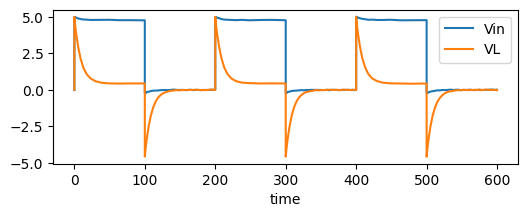

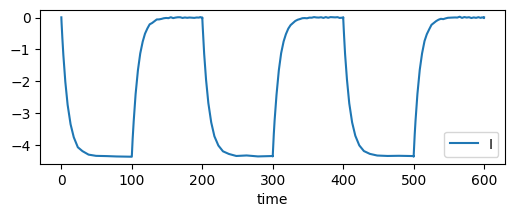

In [35]:
df.plot(x="time", y=["Vin", "VL"], kind="line", figsize=(6, 2))     # gráfico exploratorio

df.plot(x="time", y="I", kind="line", figsize=(6, 2)) 

De los gráficos podemos hacer por lo menos 3 observaciones interesantes:

- 1) Notar como el pulso cuadrado $V_{in}=V_0 - I(t)r_G$ muestra un pico en el flanco de subida y luego un decaimiento, eso es producto del efecto de la resistencia interna del generador. A $t=0$ no circula corriente por eso la tensión registrada es la tensión de alto seteada en la fuente: $V_0=5V$. A medida que crece la corriente la tensión la resistencia del generador produce una caida de potencial no despresiable que se observa en el gráfico.

- 2) Notar también que $V_L$ decáe pero no llega cero, esto es por la presencia de una resistencia interna no despresiable en el inductor $R_L$, la cuál genera un efecto análogo al observado con la resistencia del generador.

- 3) Con respecto a la corriente $I$ notar que el sentido de giro es opuesto al habitual.


### Ajuste RL - Pulso en alto

Vamos a utilizar uno de los pulsos para ajustar la corriente y la tensión en el inductor en cuando el pulso esta en alto.

Supongamos que queremos ajustar el ultimo pulso, el que va desde $t=200\mu$ a $t=300\mu$. En primer lugar tenemos que tomar los datos que solo estan en esa parte de la curva, hacemos un filtrado:

In [36]:
# Defino un tiempo inicial y uno final para el filtro
t1 = 200               
t2 = 300

# filtro los datos
df_carga = df[ (df["time"]>t1) & (df["time"]<t2) ]

El dataframe *df_carga* contiene solo la parte de la curva que nos interesa. Para checkear que tomamos los datos correctamente, utilizamos la rutina plot de pandas para hacer una inspección visual rápida:

<Axes: xlabel='time'>

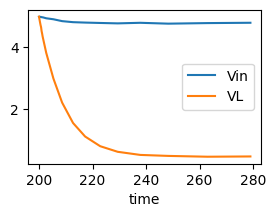

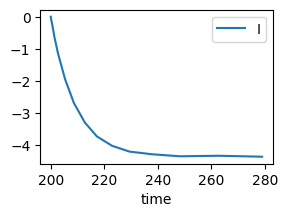

In [37]:
df_carga.plot(x="time", y=["Vin", "VL"], kind="line", figsize=(3, 2))

df_carga.plot(x="time", y="I", kind="line", figsize=(3, 2))

Como vemos el filtro funcionó correctamente.

Ahora, note que en el eje x el *tiempo cero* quedo dezplazado. Transformo los datos para que vayan desde $t=0$ a $t=0.01$, esto es un paso previo necesario para luego ejecutar correctamente el ajuste no lineal:

In [38]:
t0 = df_carga["time"].iloc[0]             # toma el primer dato
t  = df_carga["time"].to_numpy()- t0      # se lo resta a todo el array

VL = df_carga["VL"].to_numpy()   

Note que al mismo tiempo ya pasamos los datos a *numpy array* para mayor comodidad.

Con esto ya podemos hacer el ajuste, primero proponemos el modelo y las semillas (valores aproximados de los parámetros que ayudan al algoritmo a converger más rápido):

In [39]:
def modelo_VL(u, V0, tau, Voff):                         # Ec para la tensión VL en el la carga
    vl= V0*np.exp(-u/tau)+Voff
    return vl

V0_ini  = 5
tau_ini = 0.1
Voff_ini=1

Ahora ajustamos con *curve fit* para obtener los parámetros:

In [40]:
popt, pcov = curve_fit(modelo_VL, t, VL, p0=[ V0_ini, tau_ini,Voff_ini ] )      

V0, tau, Voff = popt

# Errores 
error_V0, error_tau, error_Voff = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V_0 = ({V0:.4f} ± {error_V0:.4f})")
print(f"tau = ({tau:.6f} ± {error_tau:.6f})")
print(f"Voff= ({Voff:.6f} ± {error_Voff:.6f})")

Parámetros obtenidos del ajuste:
V_0 = (4.5635 ± 0.0083)
tau = (9.026136 ± 0.055863)
Voff= (0.433918 ± 0.006931)


Graficamos datos + ajuste:

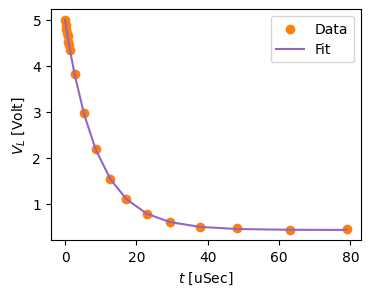

In [58]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VL ,c='C1',label='Data')                                    # datos

ax.plot( t, modelo_VL(t, V0, tau, Voff), c='C4', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [uSec]")
ax.set_ylabel("$V_L$ [Volt]")

plt.legend(loc=1)
plt.show()

Ahora hacemos lo mismo pero para la corriente:

Parámetros obtenidos del ajuste:
I_0 = (-4.346570176 ± 0.005225349)
tau = (8.959386684 ± 0.038723486)


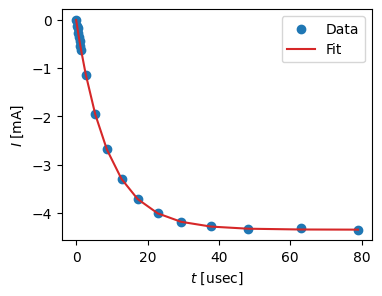

In [57]:
# Tomo data
t0 = df_carga["time"].iloc[0]
t  = df_carga["time"].to_numpy()- t0

I = df_carga["I"].to_numpy()    


# Ec para la tensión VC en el la carga
def modelo_I(u, I0, tau):                         
    i= I0*(1-np.exp(-u/tau))
    return i

# semillas
I0_ini  = -4          
tau_ini = 10
p0 = [ I0_ini,tau_ini ]

# ajuste
popt, pcov = curve_fit(modelo_I, t, I, p0=p0 )      

# param del ajuste
I0, tau = popt

# Errores
error_I0, error_tau = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"I_0 = ({I0:.9f} ± {error_I0:.9f})")
print(f"tau = ({tau:.9f} ± {error_tau:.9f})")


# Gráfico
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, I ,label='Data', c='C0')

ax.plot( t, modelo_I(t, I0, tau), c='C3', label='Fit' )

ax.set_xlabel("$t$ [usec]")
ax.set_ylabel("$I$ [mA]")
plt.legend(loc=1)
plt.show()


#### Estimación de la resistencia interna del inductor $R_L$

Se puede estimar utilizando la tensión de offset $V_{off}$ y el valor de la corriente a "t infinito", $I_0$, así

$$
R_L = \frac{V_{off}}{|I_0|}
$$

calculamos,

In [61]:
R_L = Voff/abs(I0)

print (f"R_L = {1e3*R_L:.3f} Ohm")  #recordar que I0 esta en mili ampere

R_L = 99.830 Ohm


#### Comparación $\tau_{fit}$ y $\tau_{th}$

Para hacer esta comparación es necesario tener en cuenta la presencia de las resistencias internas del generador y del inductor. Definimos entonces una resistencia equivalente $R_e = R+r_G+R_L$, luego el tiempo caracteristico teórico se calcula como:

$$
\tau_{th} = \frac{L}{R+r_G+R_L}
$$


In [72]:
L  = 10e-3
R  = 1e3
r_G= 50
R_L= 99.83

Re = R+r_G+R_L

tau_th = L/Re

print ("Comparación:")
print (f"tau_th (sin rG ni RL) = {1e6*L/R} usec")
print (f"tau_th = {1e6*tau_th:.3f} usec")
print (f"tau_fit (I)= {tau:.3f} usec")


Comparación:
tau_th (sin rG ni RL) = 10.0 usec
tau_th = 8.697 usec
tau_fit (I)= 8.959 usec


vemos como sin tener en cuenta las resistencias parásitas la comparación habría dado bastante mal